In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import utils #pywt tsfresh

## Basic EDA

[paper](https://arxiv.org/abs/1909.09347)

In [2]:
# Read data
df = utils.makeIndex(filePath = './data')

# Get ID of the closest mic to the corresponding machine_type
df['closest_mic'] = df['machine_type'].map({'valve': 0, 'pump': 2, 'fan': 4,'slider': 6})

df.head(5)

filepath  machine_id machine_type   
0  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan  \
1  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
2  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
3  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   
4  c:\Users\kalika01\Desktop\MIMII - Sound datase...           0          fan   

  background_noise    target  closest_mic  
0            -6_dB  abnormal            4  
1            -6_dB  abnormal            4  
2            -6_dB  abnormal            4  
3            -6_dB  abnormal            4  
4            -6_dB  abnormal            4

### Number of samples and class balance per machine

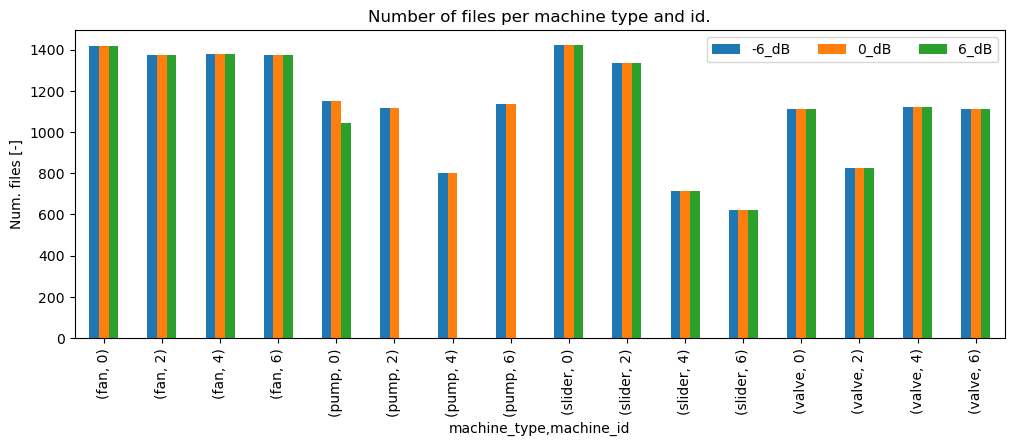

In [3]:
df.groupby(by = ['machine_type', 'machine_id', 'background_noise']).\
nunique()['filepath'].\
unstack().\
plot.bar(
    figsize = (12, 4),
    ylabel = 'Num. files [-]',
    title = 'Number of files per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

* 4 machine types (fan, pump, slider, valve)
* 4 machines per type (id 0, 2, 4, 6)
* 3 (well-balanced) background noise levels for each machine type/id (apart from pumps 2, 4, 6 which miss '6dB' background noise levels)

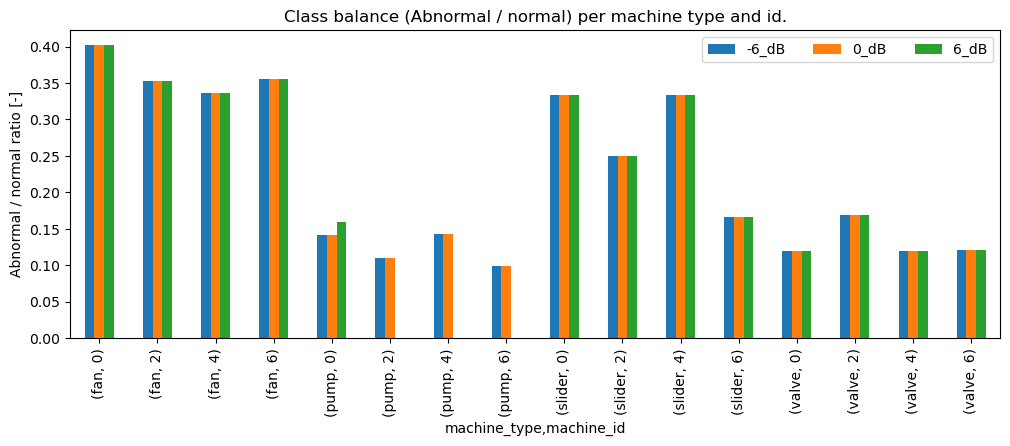

In [4]:
groups = df.groupby(by = ['machine_type', 'machine_id', 'background_noise', 'target']).\
nunique()['filepath'].\
unstack()

groups['class_balance'] = groups['abnormal'] / groups['normal']

groups['class_balance'].\
unstack().\
plot.bar(
    figsize = (12, 4),
    ylabel = 'Abnormal / normal ratio [-]',
    title = 'Class balance (Abnormal / normal) per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

Only the fans and some sliders are well-balanced. Nothing extreme though.

### Recordings

Sample waveforms that will be classified:


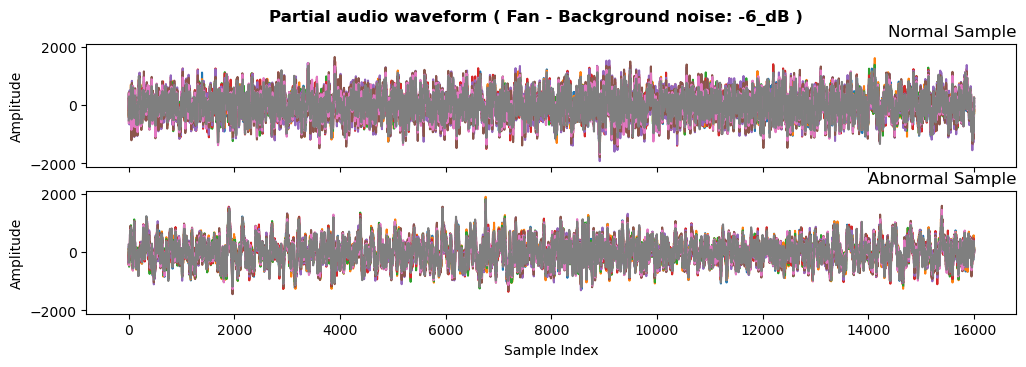

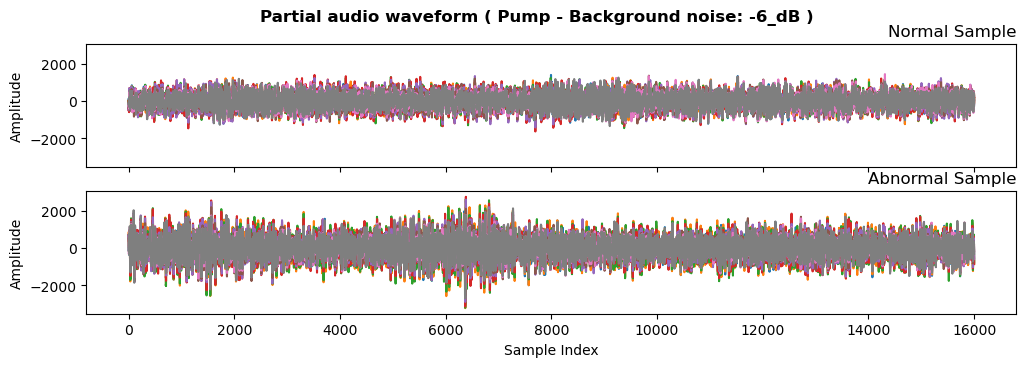

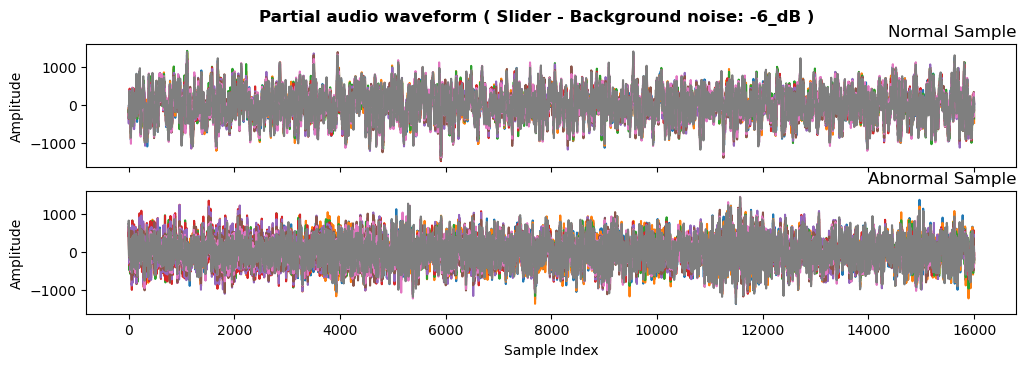

In [5]:
numPlots = 3

backNoise  = '-6_dB'
machine_id = '0'
numSamples = 16000 # Entire record is too large to be plotted
curPlot   = 0

for group, data in df.groupby(['machine_type']):

    normal   = data[(data['target'] == 'normal')   & (data['background_noise'] == backNoise)].sample()
    abnormal = data[(data['target'] == 'abnormal') & (data['background_noise'] == backNoise)].sample()

    normalFile   = normal.values[0][0]
    abnormalFile = abnormal.values[0][0]

    _, normalAudio   = utils.readWav(normalFile)
    _, abnormalAudio = utils.readWav(abnormalFile)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 3.5), sharex=True, sharey=True)
    ax[0].plot(normalAudio[0:numSamples, :])
    ax[0].set_ylabel('Amplitude')
    ax[0].set_title('Normal Sample', loc = 'right')

    ax[1].plot(abnormalAudio[0:numSamples, :])
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_title('Abnormal Sample', loc = 'right')

    t = f'Partial audio waveform ( {group[0].title()} - Background noise: {backNoise} )'
    plt.suptitle(t, weight = 'bold');
    curPlot += 1

    if curPlot == numPlots: break

## Feature extractor

* Time-domain features
    * Mean
    * Standard Deviation
    * Skewness
    * Kurtosis
    * Root-Mean-Square (RMS) value
    * Peak value
    * Shape factor
    * Crest factor
    * Impulse factor
    * Clearance factor
* Frequency-domain features
    * Location (frequency, amplitude) of the highest peak in each band of the frequency spectrume in 1/3 octave band

Steps for FFT:
* Sliding window
* Detrending
* FFT in each chunk
* FFT level average

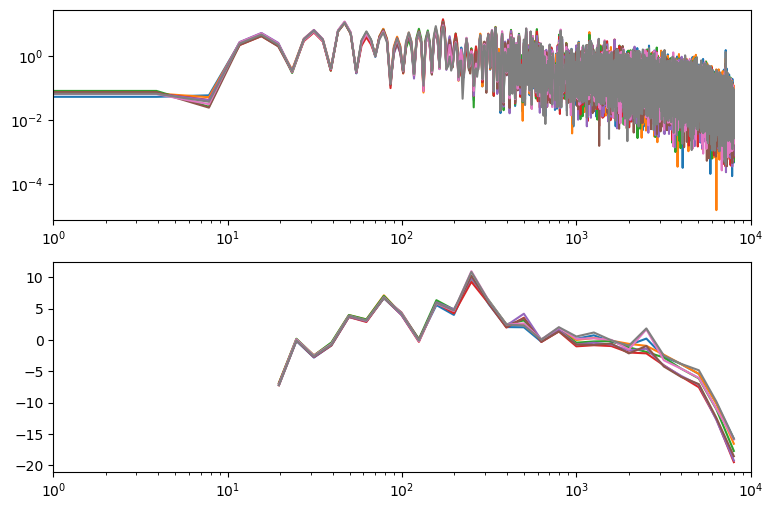

In [6]:
import preprocessing as pre
import feature_extraction as fe

normal      = data[(data['target'] == 'normal')   & (data['background_noise'] == backNoise)].sample()
normalFile  = normal.values[0][0]
sampleFrequency, signal = utils.readWav(normalFile, signalType = 'float')

# break the signal into chunks (all features will be computed per chunk - incl. time-domain features)
chunks = pre.sliceArray(signal, frameSize = 2 ** 12, hopSize = 2 ** 10, axis = 0)
chunks = pre.detrend(chunks)

# Compute FFT and power spectrum
specFrequencies, fftAmplitudes, powerAmplitudes = pre.fftSpectrum(chunks, sampleFrequency)

# Compute octave spectrum
octaveFrequencies, octaveAmplitudes = pre.octaveSpectrum(
    specFrequencies, powerAmplitudes, bandwidthDesignator = 3, referenceNoiseLevel = 20)

# Plot the various spectra
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (9, 6))
ax1.loglog(specFrequencies, np.abs(fftAmplitudes));
ax1.set_xlim([1, 10 ** 4]);
ax2.semilogx(octaveFrequencies, octaveAmplitudes);
ax2.set_xlim([1, 10 ** 4]);

In [7]:
import numpy as np
from scipy.signal import hilbert

def amplitudeEnvelope(signal: np.array, axis: int):
    """
    Computes the amplitude envelope of a signal using the Hilbert transform.
    Inputs:
        signal: The input signal.
        axis  : Axis along which the envelope will be computed
    Outputs:
        The envelope of the input signal.
    """
    analyticSignal = hilbert(signal, axis = axis)
    return np.abs(analyticSignal)


def energyEnvelope(signal, frameSize: int, hopSize: int, axis = 1):
    """
    Computes the energy (RMS) envelope of a signal.
    Inputs:
        signal   : The input signal
        frameSize: The size of each frame.
        hopSize  : The hop size between adjacent frames.
        axis     : Axis along which the envelope will be computed
    Outputs:
        The envelope of the input signal.
    """
    
    frames = pre._sliceArray(signal, frameSize = frameSize, hopSize = hopSize, axis = axis)
    return fe.rms(frames, axis = axis + 1)


def sinusoidalHarmonicModel(frequencies: np.array, amplitudes: np.array, harmonics: int, axis: int):
    """ Extracts (complex) amplitudes and frequencies of the sinusoids that best approximate a signal, by 
        analyzing the signal's spectrum and identifying the frequencies and amplitued of its spectral peaks.
        Inputs: 
            frequencies: Vector of frequencies for the corresponding FFT amplitudes
            amplitudes : FFT amplitudes [Num. frames x Num. frequencies x Num. channels]
            harmonics  : Number of harmonic frequencies and amplitudes to extract
            axis       : Axis along which to search for the harmonic amplitudes and frequencies
        Outputs:
            harmonicFreqs: Harmonic frequencies [Num. frames x harmonics x Num. channels]
            harmonicAmps:  Harmonic amplitudes  [Num. frames x harmonics x Num. channels]
    """

    # Compute the fundamental frequency
    peakIndex   = np.argmax(np.abs(amplitudes), axis = axis)
    fundamental = frequencies[peakIndex]

    # Compute sinusoidal harmonic frequencies and corresponding amplitudes
    frames, _, channels = amplitudes.shape
    harmonicFreqs = np.empty(shape = (frames, harmonics, channels))
    harmonicAmps  = np.empty(shape = (frames, harmonics, channels))

    for hNo in range(1, harmonics + 1):

        # Get the spectrum frequency that is closest to the current harmonic frequency
        diff = frequencies[:, None, None] - fundamental * hNo
        idx  = np.abs(diff).argmin(axis = 0)
        harmonicFreqs[:, hNo-1, :] = frequencies[idx]

        # get the corresponding amplitude
        curAmps = np.take_along_axis(amplitudes, idx[:, None, :], axis = axis)
        harmonicAmps[:, hNo-1, :] = np.squeeze(curAmps, axis = axis)
        
    return harmonicFreqs, harmonicAmps

In [17]:

# Compute the two envelopes
ampEnvelope = amplitudeEnvelope(chunks, axis = 1)
rmsEnvelope = energyEnvelope(chunks, frameSize = 512, hopSize = 16, axis = 1)

# Comptue FFT and power spectra
specFrequencies, fftAmplitudes, powerAmplitudes = pre.fftSpectrum(chunks, sampleFrequency, averaging = False)

# Compute harmonic model
hFreqs, hAmps  = sinusoidalHarmonicModel(specFrequencies, fftAmplitudes, harmonics = 6, axis = 1)


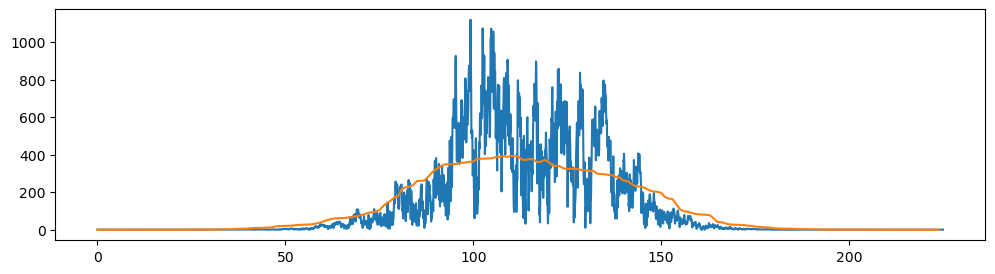

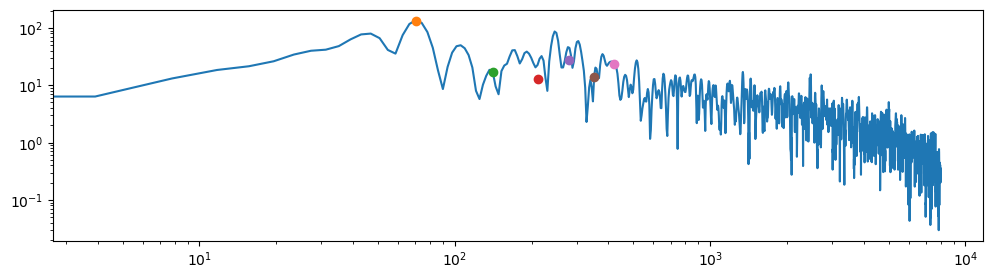

In [27]:
# Plot all

chunk, channel = 16, 1

plt.figure(figsize=(12, 3))
plt.plot(np.linspace(0, rmsEnvelope[chunk, :, channel].shape[0], ampEnvelope[chunk, :, channel].shape[0]), ampEnvelope[chunk, :, channel])
plt.plot(rmsEnvelope[chunk, :, channel])
plt.show()

plt.figure(figsize=(12, 3))
plt.loglog(specFrequencies, np.abs(fftAmplitudes[chunk,:,channel]));

for h in range(6):
    plt.loglog(hFreqs[chunk, h, channel], np.abs(hAmps[chunk, h, channel]), marker = 'o');
plt.show()

In [82]:
# spectral centroid, std, skewness, kurtosis
Sxx = powerAmplitudes
freqs = specFrequencies

# Expand dimensions for further computations
f  = freqs[:, None]
df = np.insert(np.diff(freqs), 0, 0)[:, None]

# Normalize the spectrum
Sxx = Sxx / np.sum(Sxx * df, axis = 0, keepdims = True)

# Returns moment i of the spectrum (f, Pxx) along the channel axis
moment = lambda x: np.sum((f ** x) * Sxx * df, axis = 0)

mom0 = moment(0)
mom2 = moment(2)

mean     = moment(1) / mom0
std      = np.sqrt(mom2 / mom0 - mean ** 2)
skewness = moment(3) / mom2 ** (3/2)
kurtosis = moment(4) / mom2 ** 2

print(mean)
print(std)

(36, 16384, 8)

TODO: 
* Continue the pipeline from the book

check these for another pipeline
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

check librosa for feature extraction
* https://librosa.org/doc/main/_modules/librosa/feature/spectral.html#rms